In [1]:
import sys
sys.path.append("models/vector")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch_geometric.transforms as transforms

from auxiliary.misc import get_model_name

from initialize_gnn import initialize_gnn
from dataset_vector import BuildingVectorDataset
from train_vector import train_vector_model

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, then MPS, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    vector_path = "../scratch/vector"
else:
    device = torch.device("cpu")
    # local path
    vector_path = "../data.nosync/vector"

print(f"Device set to: {device}")

Device set to: cpu


In [4]:
# operators are always specified in this order
operator_order = ("elimination", "aggregation", "typification", "displacement", "enlargement", "simplification")

In [5]:
# features are always specified in this order
feature_order = ("area", 
                 "perimeter", 
                 "convexity", 
                 "eri", 
                 "orientation_mbr", 
                 "wall_average", 
                 "voronoi_area", 
                 "impact_area", 
                 "x_coord", 
                 "y_coord")

In [6]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

### Feature importance analysis

In [7]:
def analyze_feature_importance(model_name, ops, path_to_training_data, batch_size, n_epochs):
    '''Given some model and training data, performs an ablation study to determine feature importance by first training the model 
    using the specified batch size for specified epochs on all features and subsequently removing every single feature and monitoring 
    how the loss behaves.'''
    losses_feature_sets = pd.DataFrame()

    if ops == "elimination":
        operators_to_pred = ["elimination"]
    elif ops == "selection":
        operators_to_pred = ["aggregation", "typification", "displacement", "enlargement"]
    
    features = ["area", 
                "perimeter", 
                "convexity", 
                "eri", 
                "orientation_mbr", 
                "wall_average", 
                "voronoi_area", 
                "impact_area", 
                "x_coord", 
                "y_coord"]

    # constructing feature sets to be tested
    feature_sets = {"none": features}

    for idx, feature in enumerate(features):
        feature_sets[feature] = features[:idx] + features[idx+1:]

    for excluded_feature, feature_set in feature_sets.items():
        # construct training DataLoader
        training_set = BuildingVectorDataset(path_to_training_data, 
                                             operators=operators_to_pred, 
                                             operator_order=operator_order,
                                             features=feature_set,
                                             feature_order=feature_order,
                                             attach_roads=True, 
                                             transform=None,
                                             subset=1000)

        # initialize the model
        model = initialize_gnn(model=model_name, sample=training_set.get(0), hidden_channels=128, num_heads=2, 
                               num_layers=2, node_to_predict="focal_building")
        model.to(device)

        # loss function and optimizer
        learning_rate = 0.0005
        criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # train the model and extract training losses
        _, training_losses, _, _ = train_vector_model(model=model, 
                                                      device=device, 
                                                      optimizer=optimizer, 
                                                      criterion=criterion, 
                                                      n_epochs=n_epochs, 
                                                      batch_size=batch_size, 
                                                      validate=False, 
                                                      training_set=training_set, 
                                                      validation_set=None, 
                                                      shuffle_training_set=True, 
                                                      shuffle_validation_set=False)
    
        # concatenate the loss values for the current feature set
        training_losses_df = pd.DataFrame([training_losses], index=[excluded_feature])
        training_losses_df.columns = [f"{i+1}" for i in range(len(training_losses))]

        losses_feature_sets = pd.concat([losses_feature_sets, training_losses_df])

        print(f"Finished for feature {excluded_feature}")
        
    # save the results
    model_filename = get_model_name(model, 
                                    ops=ops[:3], 
                                    attach_roads=True, 
                                    n_samples=len(training_set), 
                                    n_epochs=n_epochs, 
                                    batch_size=batch_size) + ".csv"
    feature_importance_path = os.path.join(vector_path, "model_outputs", ops, "feature_importance", model_filename)

    # save the loss values of every excluded feature
    losses_feature_sets.index.name = "excluded_feature"
    losses_feature_sets.to_csv(feature_importance_path, index=True)

In [8]:
n_epochs = 10
batch_size = 16

analyze_feature_importance(model_name="hgnn", 
                           ops="elimination", 
                           path_to_training_data=os.path.join(vector_path, "training_data", "elimination", "training"), 
                           batch_size=batch_size,
                           n_epochs=n_epochs)
analyze_feature_importance(model_name="hgt", 
                           ops="elimination", 
                           path_to_training_data=os.path.join(vector_path, "training_data", "elimination", "training"), 
                           batch_size=batch_size,
                           n_epochs=n_epochs)
#analyze_feature_importance(model_name="hgnn", 
#                           ops="selection", 
#                           path_to_training_data=os.path.join(vector_path, "training_data", "selection", "training"), 
#                           batch_size=batch_size,
#                           n_epochs=n_epochs)
#analyze_feature_importance(model_name="hgt", 
#                           ops="selection", 
#                           path_to_training_data=os.path.join(vector_path, "training_data", "selection", "training"), 
#                           batch_size=batch_size,
#                           n_epochs=n_epochs)

Number of node features: {'focal_building': 10, 'context_building': 10, 'road': 2}, 1 operators
epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.697
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.681
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.664
epoch 4/10, step 6/63
epoch 4/10, step 12/63
epoch 4/10, step 18/63
epoch 4/10, step 24/63
epoch 4/1

### Visualizing feature importance

In [9]:
def plot_feature_importance(path_to_losses_feature_sets):
    '''Visualizes the feature importance based on the results of the ablation study.'''
    # read the file
    losses = pd.read_csv(path_to_losses_feature_sets)

    # extracted feature mapping for prettier names in the plot
    feature_mapping = {"none": "none",
                       "area": "Area", 
                       "perimeter": "Perimeter",
                       "convexity": "Convexity",
                       "eri": "ERI",
                       "voronoi_area": "Voronoi area", 
                       "impact_area": "Impact area", 
                       "orientation_mbr": "MBR orientation", 
                       "wall_average": "Wall average", 
                       "x_coord": "x-coordinate", 
                       "y_coord": "y-coordinate"}
    losses["excluded_feature"] = losses["excluded_feature"].map(feature_mapping)

    # figure out the last epoch
    n_epochs = max([int(column) for column in list(losses.columns)[1:]])
    
    # extracting the loss when the model is fit with all features
    loss_all_features = losses[losses["excluded_feature"] == "none"][str(n_epochs)].item()

    # subtracting loss of all features from loss associated with excluded features
    losses_excluded_features = losses[losses["excluded_feature"] != "none"]
    losses_excluded_features = losses_excluded_features.assign(loss_change = losses_excluded_features[str(n_epochs)] - loss_all_features)

    # sorting by loss change in descending order
    losses_excluded_features = losses_excluded_features.sort_values(by="loss_change", ascending=False)

    # creating a barplot to visualize feature importance
    fig, ax = plt.subplots(figsize=(10,6))

    bars = ax.bar(losses_excluded_features["excluded_feature"], losses_excluded_features["loss_change"], color="black")
    ax.set_ylabel(f"Loss change after {n_epochs} epochs", fontsize=15)
    ax.set_xlabel("Removed feature", fontsize=15)
    ax.tick_params(axis="both", which="major", labelsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    for bar, value in zip(bars, losses_excluded_features["loss_change"]):
        # position of the text depending on the sign of the value
        y_pos = bar.get_height() + 0.00001 if value >= 0 else bar.get_height() - 0.0001
        # vertical alignment depending on the sign
        va = "bottom" if value >= 0 else "top"
        ax.text(bar.get_x() + bar.get_width() / 2, y_pos, f'{value:.4f}', 
                ha="center", va=va, fontsize=12, color="black")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

/var/folders/1z/h60fp72j6db4pn4cp9swm6p40000gn/T/ipykernel_18416/953835227.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


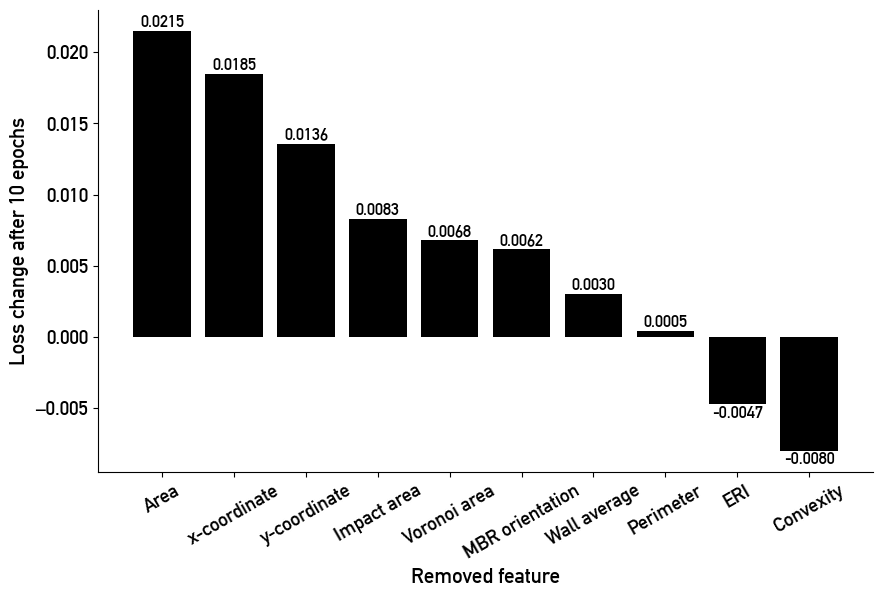

In [10]:
elimination_results_hgnn = "HGNN_eli_attachRoadsTrue_260353p_1000s_10ep_bs16.csv"
feature_importance_path = os.path.join(vector_path, "model_outputs", "elimination", "feature_importance", elimination_results_hgnn)
plot_feature_importance(feature_importance_path)

/var/folders/1z/h60fp72j6db4pn4cp9swm6p40000gn/T/ipykernel_18416/953835227.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


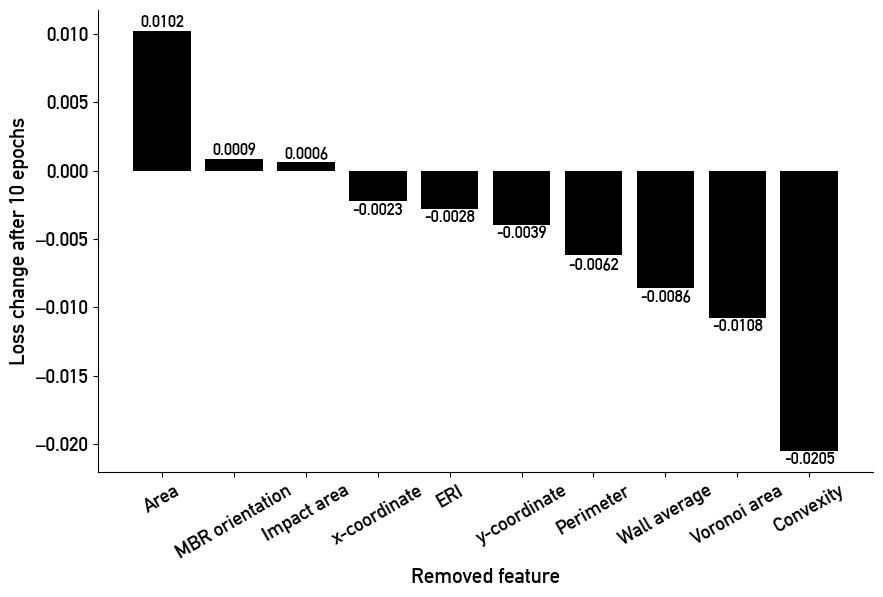

In [11]:
elimination_results_hgt = "HGT_eli_attachRoadsTrue_645283p_1000s_10ep_bs16.csv"
feature_importance_path = os.path.join(vector_path, "model_outputs", "elimination", "feature_importance", elimination_results_hgt)
plot_feature_importance(feature_importance_path)